In [1]:
from functions import *

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
from rasterio.transform import from_origin
import shutil

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load data

In [3]:
W = 256
source_path = '../data/raw/'
data_paths = ['lst', 'ndvi', 'wt', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
list_rgb = [True,False,False,False]

In [4]:
data, time_slots = load_data(dir_paths,W,list_rgb)

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


In [5]:
data_inputs = data[dir_paths[0]]
ndvi = data[dir_paths[1]]
data_targets = data[dir_paths[2]]
wt_stations = data[dir_paths[3]]
print('inputs shape:', data_inputs.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (108, 256, 256, 3) (108, 256, 256)
targets shape: (108, 256, 256)


In [6]:
start_date = '2013-03'
end_date = '2023-07'

# Generar el rango de fechas en formato YYYY-MM
date_range = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m')

# Convertir a un array de numpy (opcional, si quieres un array en lugar de un pandas Index)
time_slots = date_range.to_numpy()
time_slots

array(['2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12', 

In [7]:
gdf_points = gpd.read_file('../data/external/wt_filtered/wt_filtered.geojson')
time_slots = gdf_points.time.dt.strftime("%Y-%m").unique()
months = gdf_points.time.dt.month.unique()

In [8]:
time_slots

array(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', 

# Delete unuseful data

In [9]:
'''new_inputs = []
new_targets = []
new_masked_inputs = []
del_indices = []
for index in range(0,data_inputs.shape[0]):
  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])

  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100

  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):
    new_inputs.append(data_inputs[index])
    new_targets.append(data_targets[index])
    new_masked_inputs.append(masked_inputs[index])
  else:
    del_indices.append(index)

new_inputs = np.array(new_inputs)
new_targets = np.array(new_targets)
new_masked_inputs = np.array(new_masked_inputs)
slots = np.delete(time_slots,del_indices)'''

'new_inputs = []\nnew_targets = []\nnew_masked_inputs = []\ndel_indices = []\nfor index in range(0,data_inputs.shape[0]):\n  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])\n\n  blacks = img_gray==0\n  percentage_b = np.sum(blacks)/blacks.size * 100\n\n  whites = img_gray>=240\n  percentage_w = np.sum(whites)/whites.size * 100\n\n  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):\n    new_inputs.append(data_inputs[index])\n    new_targets.append(data_targets[index])\n    new_masked_inputs.append(masked_inputs[index])\n  else:\n    del_indices.append(index)\n\nnew_inputs = np.array(new_inputs)\nnew_targets = np.array(new_targets)\nnew_masked_inputs = np.array(new_masked_inputs)\nslots = np.delete(time_slots,del_indices)'

Including NDVI data

In [10]:
del_indices = []
fixed_ndvi = []
for index in range(0,data_inputs.shape[0]):
  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])

  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100

  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  img_ndvi = ndvi[index]

  whites = np.isnan(img_ndvi)
  percentage_w_ndvi = np.sum(whites)/whites.size * 100

  if np.all(img_gray == 255) or np.all(img_gray == 0) or np.all(img_gray == img_gray[0,0]) or (percentage_b > 50) or (percentage_w > 50) \
    or np.all(np.isnan(img_ndvi)) or np.all(img_ndvi == img_ndvi[0,0]) or (percentage_w_ndvi > 50):
    del_indices.append(index)
  else:
    new_ndvi = np.where(whites, 0.0, img_ndvi) # process ndvi images to not have nans
    fixed_ndvi.append(new_ndvi)


In [11]:
fixed_ndvi = np.array(fixed_ndvi)

In [12]:
slots = np.delete(time_slots,del_indices)

In [13]:
len(slots)

13

# Mask Landsat data

In [14]:
# Selecciona la imagen en el índice 0 (la primera imagen)
river_mask = data_targets[0]  # Cambia el índice según sea necesario

# Imprimir la forma de la imagen seleccionada
print('Selected image shape:', river_mask.shape)

Selected image shape: (256, 256)


In [15]:
# Supongamos que river_mask es tu máscara de río de forma (height, width)
# y que quieres que tenga 3 canales (para las imágenes RGB de data_inputs)
river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
river_mask_expanded = np.repeat(river_mask_expanded, data_inputs.shape[-1], axis=-1)  # Expande a (height, width, 3)

# Aplica la máscara solo a las entradas (inputs)
masked_inputs = []

for i,input_img in enumerate(data_inputs):
  if i not in del_indices:
    masked_input = input_img * river_mask_expanded  # Aplica la máscara a los inputs
    masked_inputs.append(masked_input)

# Convierte de nuevo a arrays de numpy
masked_inputs = np.array(masked_inputs)

# Verifica las formas
print('masked inputs shape:', masked_inputs.shape)

masked inputs shape: (13, 256, 256, 3)


# Mask NDVI data

In [16]:
masked_inputs_ndvi = []

for i,input_img in enumerate(fixed_ndvi):
    masked_input_ndvi = input_img * river_mask  # Aplica la máscara a los inputs
    masked_inputs_ndvi.append(masked_input_ndvi)

# Convierte de nuevo a arrays de numpy
masked_inputs_ndvi = np.array(masked_inputs_ndvi)

# Verifica las formas
print('masked inputs shape:', masked_inputs_ndvi.shape)

masked inputs shape: (13, 256, 256)


# Download preprocessed data

In [17]:
boiron = gpd.read_file('../data/external/swissTLMboiron')

bounds = boiron.total_bounds
# Definir la resolución
resolution = 30
x_min, y_min, x_max, y_max = bounds

transform = from_origin(x_min, y_max, resolution, resolution)  # Origen en la esquina superior izquierda

In [18]:
# Function to clear the contents of a directory
def clear_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Error deleting {file_path}. Reason: {e}')

In [19]:
def save_raster(raster_array,filepath,shp):
  resolution = 30
  x_min, y_min, x_max, y_max = shp.total_bounds
  transform = from_origin(x_min, y_max, resolution, resolution)

  with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=raster_array.shape[0],
        width=raster_array.shape[1],
        count=len(raster_array.shape),
        dtype=raster_array.dtype,
        crs=shp.crs.to_string(),  # Ensure correct CRS
        transform=transform,
        nodata=0.0
) as dst:
    if len(raster_array.shape) == 3:
      dst.write(raster_array[:, :, 0], 1)  # Red channel
      dst.write(raster_array[:, :, 1], 2)  # Green channel
      dst.write(raster_array[:, :, 2], 3)  # Blue channel
    else:
      dst.write(raster_array, 1)

Clean preprocessed directories

In [20]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['wt', 'lst', 'ndvi', 'wt_interpolated','wt']#, 'lst/masked']
for d in data:
  dest_dir = os.path.join(preprocessed_data_path, d)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)
  if d == 'lst':
    dest_dir_m = os.path.join(dest_dir, 'masked')
    os.makedirs(dest_dir_m, exist_ok=True)
    clear_directory(dest_dir_m)

Copy preprocessed images

In [21]:
for d in data:
  source_dir = os.path.join(raw_data_path, d)
  dest_dir = os.path.join(preprocessed_data_path, d)

  # List all files in the source directory
  all_images = os.listdir(source_dir)
  count = 0
  # Loop through each file and check if it contains any of the slots
  for ind, image_file in enumerate(all_images):
      # Check if the image filename contains any of the time slots
      if any(slot in image_file for slot in slots):
          # Construct full file paths
          if d == 'ndvi':
            date = image_file.split('_')[1].split('.')[0]
            name = f'{dest_dir}/ndvi_{date}.tiff'
            save_raster(fixed_ndvi[count], name, boiron)
            print(f'Copied: ndvi_{date}, at {dest_dir}')
          else:
            dst_path = os.path.join(dest_dir, image_file)
            src_path = os.path.join(source_dir, image_file)
            # Copy the file to the destination folder
            shutil.copy(src_path, dst_path)
            print()
            print('Image', count)
            print(f'Copied: {image_file}, from {src_path}, to {dst_path}')

            if d == 'lst':
              date = image_file.split('_')[1].split('.')[0]
              name = f'{dest_dir}/masked/lst_masked_{date}.tiff'
              save_raster(masked_inputs[count], name, boiron)
              print(f'Copied: lst_masked_{date}')

          count+=1





Image 0
Copied: raster_mask_temp_2012-04.tif, from ../data/raw/wt/raster_mask_temp_2012-04.tif, to ../data/preprocessed/wt/raster_mask_temp_2012-04.tif

Image 1
Copied: raster_mask_temp_2012-03.tif, from ../data/raw/wt/raster_mask_temp_2012-03.tif, to ../data/preprocessed/wt/raster_mask_temp_2012-03.tif

Image 2
Copied: raster_mask_temp_2015-09.tif, from ../data/raw/wt/raster_mask_temp_2015-09.tif, to ../data/preprocessed/wt/raster_mask_temp_2015-09.tif

Image 3
Copied: raster_mask_temp_2016-10.tif, from ../data/raw/wt/raster_mask_temp_2016-10.tif, to ../data/preprocessed/wt/raster_mask_temp_2016-10.tif

Image 4
Copied: raster_mask_temp_2016-04.tif, from ../data/raw/wt/raster_mask_temp_2016-04.tif, to ../data/preprocessed/wt/raster_mask_temp_2016-04.tif

Image 5
Copied: raster_mask_temp_2016-11.tif, from ../data/raw/wt/raster_mask_temp_2016-11.tif, to ../data/preprocessed/wt/raster_mask_temp_2016-11.tif

Image 6
Copied: raster_mask_temp_2014-02.tif, from ../data/raw/wt/raster_mask_tem

CHECK

In [22]:
dir_paths = ['../data/preprocessed/ndvi']
W = 256
list_rgb = [False]
data, time_slots = load_data(dir_paths,W,list_rgb)

(13, 256, 256)
0


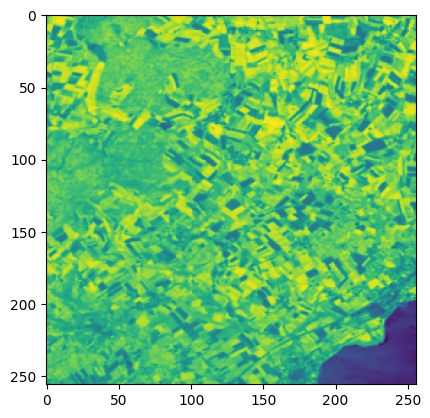

0


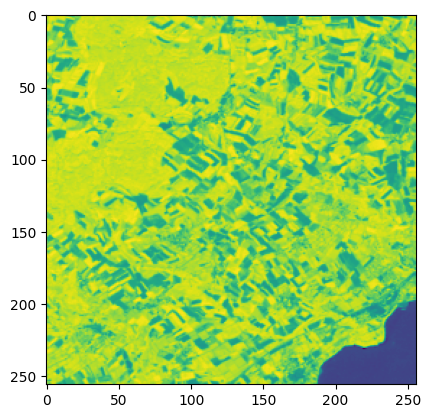

0


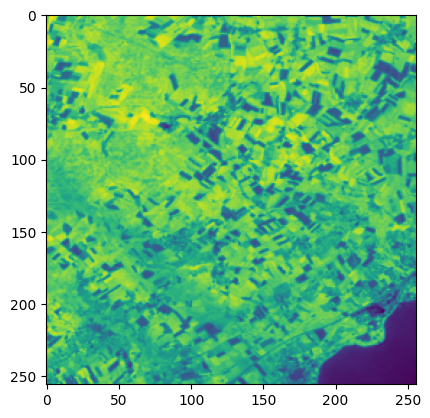

0


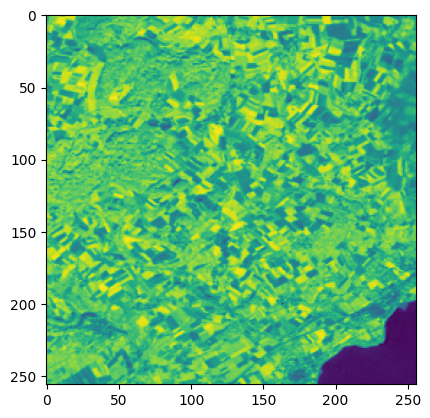

0


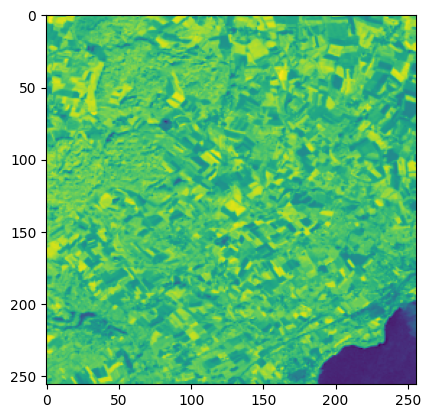

0


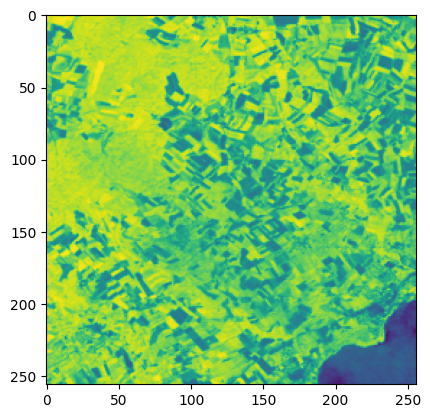

0


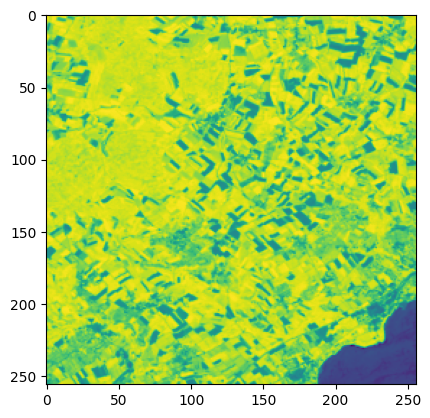

0


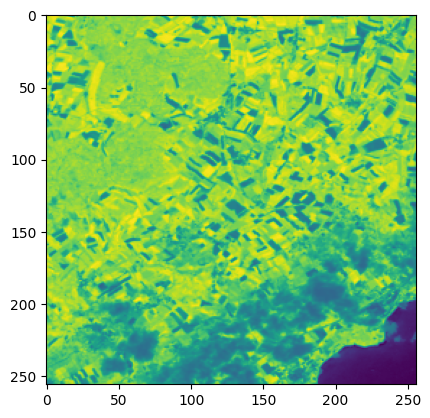

0


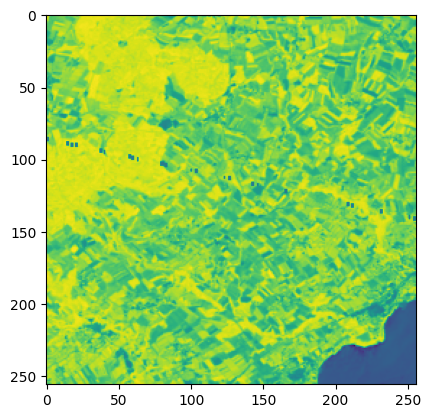

0


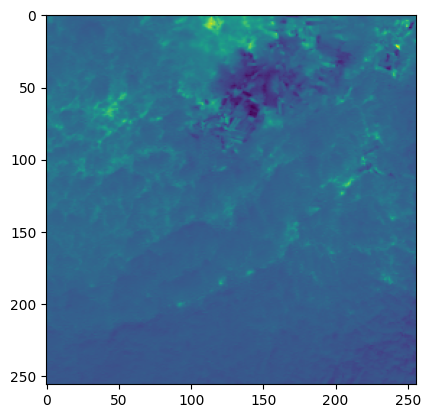

0


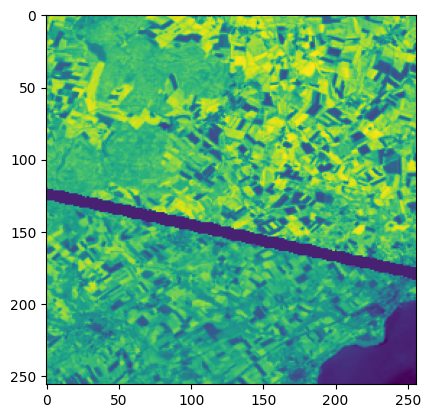

0


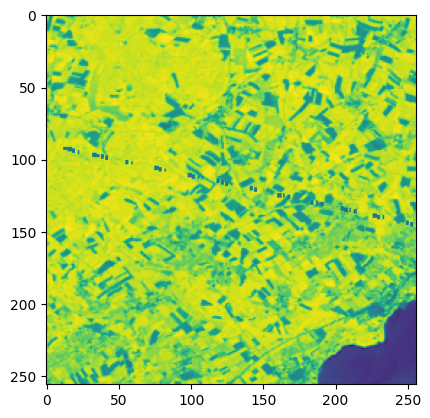

0


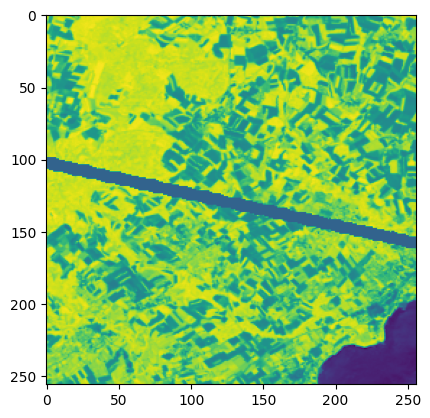

In [23]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(i)
  plt.show()

# Pixel wise dataset creation

In [24]:
river_indices = np.nonzero(river_mask.reshape(-1))[0]

In [25]:
len(river_indices)

4215

### LST dataset

In [26]:
pixel_ds_lst = pd.DataFrame(columns=[river_indices])
pixel_ds_lst

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [27]:
for i,image in enumerate(masked_inputs):
  img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution

  flat_image = img_gray.flatten()

  river_image = flat_image[river_indices]
  pixel_ds_lst.loc[slots[i]] = river_image

In [28]:
pixel_ds_lst

29         30         31         285        286       287    \
2012-03  55.755234  43.149469  25.088055  54.328115  28.526325  0.000611   
2012-04  61.266236  47.620025  27.673963  60.111527  31.417559  0.000670   
2014-02  43.159259  33.078996  19.005308  42.060504  21.975468  0.000470   
2014-08  56.390374  44.002667  25.782475  55.512061  29.136687  0.000625   
2015-05  56.212870  43.788120  25.462259  55.512060  28.993794  0.000620   
2015-06  63.120341  49.259814  28.647115  62.373031  32.752187  0.000698   
2015-09  30.792102  23.670618  13.674815  29.709338  15.466819  0.000330   
2016-04  55.089666  42.809065  24.867428  53.897715  28.285980  0.000602   
2016-09  45.648504  35.657043  20.880175  44.775240  23.335850  0.000499   
2016-10  39.465324  30.312211  17.566322  38.245350  19.848703  0.000424   
2016-11  11.783332   9.260437   5.292852  11.704007   6.167620  0.000132   
2017-05   8.451014   6.470208   3.742046   7.828160   4.125177  0.000088   
2019-01  39.324859  30.376452  17.603963  38.428225  20.061380  0.000431   

             541        542        797        798    ...      65207  \
2012-03  10.726321  41.926670  52.652330  17.233451  ...  37.342961   
2012-04  11.810758  45.785365  58.015296  18.917923  ...  50.565594   
2014-02   8.288998  32.228627  40.992362  13.346206  ...  29.025641   
2014-08  11.047463  43.181935  55.189222  18.063792  ...  35.147128   
2015-05  11.010464  42.656973  54.162633  17.647336  ...  59.182801   
2015-06  12.371325  48.186490  60.965854  19.954521  ...  62.938223   
2015-09   5.763649  22.528749  28.341916   9.276494  ...  23.755445   
2016-04  10.646740  41.615605  52.652329  17.268987  ...  34.022554   
2016-09   8.768832  33.893960  42.810172  13.818591  ...  16.154127   
2016-10   7.488491  28.889406  36.945165  11.963400  ...  27.138163   
2016-11   2.277692   9.074079  11.352460   3.757670  ...   6.151573   
2017-05   1.520706   5.945086   7.232039   2.444566  ...   7.893447   
2019-01   7.561293  29.726664  37.520430  12.432203  ...  27.150098   

             65208     65209     65210     65461     65462      65463  \
2012-03   6.815878  0.001314  0.001192  0.000214  0.001087   9.788662   
2012-04   9.170766  0.001690  0.001409  0.000285  0.001433  12.950627   
2014-02   5.389397  0.001053  0.000939  0.000161  0.000819   7.373843   
2014-08   6.460396  0.001265  0.001131  0.000212  0.001069   9.442053   
2015-05  10.715633  0.002026  0.001730  0.000333  0.001699  15.310265   
2015-06  11.568216  0.002172  0.001722  0.000353  0.001799  16.307066   
2015-09   4.505029  0.000902  0.000837  0.000129  0.000659   6.037590   
2016-04   6.389747  0.001270  0.001167  0.000188  0.000957   8.693935   
2016-09   2.971541  0.000579  0.000521  0.000094  0.000472   4.202899   
2016-10   5.119658  0.001023  0.000947  0.000150  0.000760   6.853432   
2016-11   1.199072  0.000252  0.000242  0.000033  0.000166   1.520445   
2017-05   1.477481  0.000296  0.000274  0.000045  0.000230   2.010708   
2019-01   4.993668  0.000964  0.000851  0.000154  0.000775   6.968856   

             65464      65465      65466  
2012-03  47.557652  55.866258  50.233467  
2012-04  63.100442  74.000236  63.024622  
2014-02  36.191042  44.093145  39.729152  
2014-08  44.860900  53.641876  48.362177  
2015-05  74.532083  89.233823  77.890775  
2015-06  79.874534  92.489476  73.292760  
2015-09  30.142587  37.458161  34.583462  
2016-04  43.193250  53.098380  48.723000  
2016-09  20.530234  25.241562  22.534612  
2016-10  34.116344  42.247980  39.303488  
2016-11   7.894425  10.110668   9.900011  
2017-05   9.817282  11.986739  11.181094  
2019-01  34.016094  41.080735  36.253791  

[13 rows x 4215 columns]

In [29]:
pixel_ds_lst.to_csv('../data/preprocessed/lst/leboiron_lst.csv')

### NDVI dataset

In [30]:
pixel_ds_ndvi = pd.DataFrame(columns=[river_indices])
pixel_ds_ndvi

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [31]:
for i,image in enumerate(masked_inputs_ndvi):
  flat_image = image.flatten()
  river_image = flat_image[river_indices]

  #print(flat_image.shape, river_image.shape)

  pixel_ds_ndvi.loc[slots[i]] = river_image

In [32]:
pixel_ds_ndvi

29        30        31        285       286       287       541    \
2012-03  1.051202  0.823306  0.481461  1.022978  0.548937  0.000012  0.190852   
2012-04  0.553098  0.386566  0.225621  0.523765  0.249093  0.000006  0.096119   
2014-02  0.578252  0.438953  0.227454  0.515337  0.265626  0.000005  0.095653   
2014-08  1.117653  0.870737  0.499254  1.099600  0.581107  0.000012  0.220851   
2015-05  1.084460  0.844600  0.493849  1.067573  0.568125  0.000012  0.193978   
2015-06  0.925930  0.723838  0.419402  0.918155  0.489469  0.000011  0.153697   
2015-09  0.811571  0.636661  0.372284  0.805293  0.430189  0.000009  0.144046   
2016-04  1.139287  0.893346  0.512882  1.123127  0.595756  0.000013  0.224385   
2016-09  0.156490  0.120257  0.064717  0.133249  0.072203  0.000002  0.029615   
2016-10  1.050665  0.808981  0.472953  1.015575  0.538400  0.000012  0.202291   
2016-11  0.624407  0.503015  0.290259  0.564941  0.327305  0.000007  0.092534   
2017-05  1.096326  0.842844  0.483001  1.061254  0.553418  0.000012  0.212623   
2019-01  0.629246  0.480022  0.282454  0.579593  0.315950  0.000007  0.098149   

            542       797       798    ...     65207     65208     65209  \
2012-03  0.790451  0.950917  0.332063  ...  0.378827  0.085521  0.000019   
2012-04  0.356929  0.396695  0.148172  ...  0.255397  0.065545  0.000012   
2014-02  0.376464  0.416130  0.148518  ...  0.274926  0.058701  0.000013   
2014-08  0.859384  1.088383  0.353273  ...  0.391763  0.083359  0.000018   
2015-05  0.823312  1.025877  0.341396  ...  0.388452  0.084497  0.000019   
2015-06  0.688124  0.861479  0.286641  ...  0.408562  0.083900  0.000018   
2015-09  0.609377  0.767380  0.258043  ...  0.286822  0.063836  0.000013   
2016-04  0.878107  1.111943  0.362498  ...  0.404067  0.078997  0.000016   
2016-09  0.110108  0.121485  0.041988  ...  0.032871  0.006747  0.000001   
2016-10  0.800442  0.986846  0.322112  ...  0.394476  0.084375  0.000017   
2016-11  0.457230  0.533457  0.185391  ...  0.290820  0.063962  0.000013   
2017-05  0.814058  1.034772  0.337285  ...  0.365163  0.065920  0.000013   
2019-01  0.431324  0.527082  0.186607  ...  0.284092  0.065129  0.000013   

            65210         65461     65462     65463     65464     65465  \
2012-03  0.000017  2.575839e-06  0.000013  0.110166  0.473979  0.551381   
2012-04  0.000009  1.930824e-06  0.000009  0.071516  0.344343  0.378336   
2014-02  0.000009  1.842788e-06  0.000009  0.079435  0.323228  0.394985   
2014-08  0.000017  2.367085e-06  0.000013  0.110417  0.398530  0.446895   
2015-05  0.000018  2.601132e-06  0.000014  0.111458  0.429902  0.484480   
2015-06  0.000016  2.290947e-06  0.000011  0.094582  0.431779  0.480763   
2015-09  0.000012  1.641115e-06  0.000008  0.068505  0.334301  0.363613   
2016-04  0.000016  2.412278e-06  0.000012  0.110456  0.434391  0.461766   
2016-09  0.000001  2.080542e-07  0.000001  0.008851  0.046174  0.056101   
2016-10  0.000016  2.497664e-06  0.000013  0.096091  0.481077  0.466297   
2016-11  0.000012  1.988123e-06  0.000010  0.079915  0.333265  0.348376   
2017-05  0.000014  2.505488e-06  0.000013  0.104663  0.402631  0.423186   
2019-01  0.000011  2.029252e-06  0.000010  0.078105  0.327946  0.361599   

            65466  
2012-03  0.473967  
2012-04  0.393361  
2014-02  0.416770  
2014-08  0.455548  
2015-05  0.507788  
2015-06  0.422888  
2015-09  0.359399  
2016-04  0.419535  
2016-09  0.059160  
2016-10  0.471807  
2016-11  0.375187  
2017-05  0.425292  
2019-01  0.366029  

[13 rows x 4215 columns]

In [33]:
pixel_ds_ndvi.to_csv('../data/preprocessed/ndvi/leboiron_ndvi.csv')

### Water temperature dataset

In [34]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [35]:
c = 0
for i in range(len(data_targets)):
  if i not in del_indices:
    image = data_targets[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [36]:
pixel_ds_wt

29         30        31         285       286       287    \
2012-03   7.929246   6.231538  3.651244   7.875867  4.150318  0.000089   
2012-04  10.057624   7.904215  4.631315   9.989917  5.264352  0.000113   
2014-02   4.671031   3.670930  2.150907   4.639585  2.444906  0.000052   
2014-08  17.355047  13.639208  7.991619  17.238214  9.083961  0.000195   
2015-05  14.128395  11.103405  6.505816  14.033284  7.395071  0.000159   
2015-06  18.824598  14.794118  8.668315  18.697872  9.853152  0.000211   
2015-09  15.024829  11.807906  6.918604  14.923683  7.864281  0.000169   
2016-04  10.614913   8.342185  4.887935  10.543455  5.556048  0.000119   
2016-09  18.182919  14.289826  8.372836  18.060514  9.517286  0.000204   
2016-10   9.548893   7.504407  4.397057   9.484612  4.998072  0.000107   
2016-11   5.695368   4.475949  2.622592   5.657027  2.981064  0.000064   
2017-05  15.122702  11.884824  6.963673  15.020898  7.915510  0.000170   
2019-01   1.305214   1.025758  0.601022   1.296427  0.683174  0.000015   

            541        542        797       798    ...     65207     65208  \
2012-03  1.562165   6.106134   7.725520  2.528613  ...  3.915490  0.746173   
2012-04  1.981483   7.745150   9.799213  3.207347  ...  4.966491  0.946462   
2014-02  0.920254   3.597056   4.551018  1.489578  ...  2.306572  0.439562   
2014-08  3.419170  13.364732  16.909143  5.534473  ...  8.569984  1.633178   
2015-05  2.783478  10.879959  13.765394  4.505503  ...  6.976652  1.329537   
2015-06  3.708691  14.496400  18.340939  6.003109  ...  9.295654  1.771468   
2015-09  2.960087  11.570283  14.638797  4.791374  ...  7.419314  1.413895   
2016-04  2.091276   8.174306  10.342185  3.385065  ...  5.241682  0.998905   
2016-09  3.582272  14.002257  17.715746  5.798479  ...  8.978790  1.711084   
2016-10  1.881256   7.353388   9.303554  3.045114  ...  4.715278  0.898588   
2016-11  1.122062   4.385875   5.549037  1.816236  ...  2.812393  0.535956   
2017-05  2.979369  11.645653  14.734155  4.822585  ...  7.467644  1.423105   
2019-01  0.257144   1.005116   1.271679  0.416229  ...  0.644519  0.122826   

            65209     65210     65461     65462     65463      65464  \
2012-03  0.000152  0.000144  0.000021  0.000107  0.984420   4.958027   
2012-04  0.000193  0.000182  0.000027  0.000136  1.248659   6.288866   
2014-02  0.000089  0.000085  0.000012  0.000063  0.579911   2.920719   
2014-08  0.000332  0.000314  0.000046  0.000235  2.154637  10.851825   
2015-05  0.000271  0.000256  0.000037  0.000191  1.754047   8.834252   
2015-06  0.000360  0.000341  0.000050  0.000255  2.337083  11.770711   
2015-09  0.000288  0.000272  0.000040  0.000203  1.865340   9.394777   
2016-04  0.000203  0.000192  0.000028  0.000144  1.317847   6.637330   
2016-09  0.000348  0.000329  0.000048  0.000246  2.257418  11.369480   
2016-10  0.000183  0.000173  0.000025  0.000129  1.185500   5.970766   
2016-11  0.000109  0.000103  0.000015  0.000077  0.707083   3.561220   
2017-05  0.000290  0.000274  0.000040  0.000205  1.877491   9.455976   
2019-01  0.000025  0.000024  0.000003  0.000018  0.162043   0.816129   

             65465      65466  
2012-03   6.231457   5.890674  
2012-04   7.904111   7.471856  
2014-02   3.670882   3.470131  
2014-08  13.639030  12.893146  
2015-05  11.103260  10.496051  
2015-06  14.793924  13.984881  
2015-09  11.807752  11.162015  
2016-04   8.342075   7.885869  
2016-09  14.289640  13.508176  
2016-10   7.504310   7.093918  
2016-11   4.475891   4.231115  
2017-05  11.884668  11.234726  
2019-01   1.025745   0.969650  

[13 rows x 4215 columns]

In [37]:
pixel_ds_wt.to_csv('../data/preprocessed/wt/leboiron_wt.csv')

### Water temperature stations dataset

In [38]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [41]:
wt_stations.shape

(125, 256, 256)

In [43]:
c = 0
for i in range(len(wt_stations)):
  if i not in del_indices and i <= len(slots):
    image = wt_stations[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [44]:
pixel_ds_wt

29         30         31        285        286       287    \
2012-03  2.468804   8.304325   6.795494  3.233954   8.104184  3.499145   
2012-04  2.750221   9.250875   7.570085  3.602597   9.027983  3.898015   
2014-02  3.426578  11.526873   9.433208  4.488359  11.246246  4.855289   
2014-08  3.665503  12.330420  10.090839  4.801402  12.031331  5.194518   
2015-05  3.700902  12.449160  10.187893  4.847870  12.148521  5.245405   
2015-06  3.470196  11.672450   9.551773  4.545773  11.391972  4.918897   
2015-09  3.284051  11.045554   9.038274  4.302092  10.782201  4.655923   
2016-04  2.636063   8.865178   7.253474  3.453427   8.656421  3.738394   
2016-09  1.894325   6.369037   5.210031  2.482054   6.223749  2.688580   
2016-10  1.526544   5.132484   4.198341  2.000151   5.015229  2.166437   
2016-11  1.265771   4.255412   3.480612  1.658538   4.159047  1.796715   
2017-05  1.875099   6.305809   5.159029  2.456527   6.157527  2.659155   
2019-01  2.389212   8.035885   6.575341  3.129825   7.843899  3.386980   

            541        542       797       798    ...     65207     65208  \
2012-03  0.617803   8.503781  0.617806  6.658625  ...  5.076975  0.968408   
2012-04  0.688223   9.473084  0.688224  7.417587  ...  5.586770  1.065609   
2014-02  0.857047  11.797072  0.856826  9.234747  ...  7.223573  1.377528   
2014-08  0.916997  12.622202  0.916842  9.881592  ...  7.660760  1.460876   
2015-05  0.926064  12.746926  0.926007  9.980371  ...  7.633008  1.455777   
2015-06  0.868501  11.954502  0.868548  9.361088  ...  6.936604  1.322857   
2015-09  0.822193  11.316967  0.822388  8.863589  ...  6.337979  1.208879   
2016-04  0.660332   9.088876  0.660687  7.120791  ...  4.881415  0.931167   
2016-09  0.475193   6.540301  0.475802  5.128129  ...  3.177609  0.606796   
2016-10  0.382904   5.270087  0.383389  4.132118  ...  2.616223  0.499446   
2016-11  0.317617   4.371457  0.318090  3.428325  ...  2.145517  0.409661   
2017-05  0.469722   6.465285  0.470000  5.065597  ...  3.505339  0.668805   
2019-01  0.598097   8.232433  0.598221  6.447540  ...  4.752712  0.906617   

            65209     65210     65461     65462     65463     65464  \
2012-03  0.000197  0.000187  0.000027  0.000139  1.277613  6.439914   
2012-04  0.000217  0.000206  0.000030  0.000153  1.405849  7.086148   
2014-02  0.000281  0.000266  0.000039  0.000198  1.817361  9.158693   
2014-08  0.000298  0.000282  0.000041  0.000210  1.927321  9.712732   
2015-05  0.000297  0.000281  0.000041  0.000209  1.920594  9.680247   
2015-06  0.000270  0.000255  0.000037  0.000190  1.745233  8.795513   
2015-09  0.000246  0.000233  0.000034  0.000174  1.594864  8.038973   
2016-04  0.000190  0.000180  0.000026  0.000134  1.228481  6.192655   
2016-09  0.000124  0.000117  0.000017  0.000087  0.800541  4.039757   
2016-10  0.000102  0.000097  0.000014  0.000072  0.658914  3.323695   
2016-11  0.000084  0.000079  0.000011  0.000059  0.540462  2.726483   
2017-05  0.000136  0.000129  0.000019  0.000096  0.882348  4.448438   
2019-01  0.000185  0.000175  0.000025  0.000130  1.196092  6.029368   

             65465      65466  
2012-03   8.104325   7.665516  
2012-04   8.917316   8.434641  
2014-02  11.523288  10.899286  
2014-08  12.220199  11.558540  
2015-05  12.181987  11.524298  
2015-06  11.066760  10.467578  
2015-09  10.116733   9.569892  
2016-04   7.793813   7.372122  
2016-09   5.091907   4.820627  
2016-10   4.186709   3.961149  
2016-11   3.434859   3.249492  
2017-05   5.599468   5.296111  
2019-01   7.588565   7.178185  

[13 rows x 4215 columns]

In [45]:
pixel_ds_wt.to_csv('../data/preprocessed/wt_interpolated/leboiron_wt_interpolated.csv')